# Contents

## Import Libraries

In [1]:
# import Libraries
import pandas as pd
import sweetviz as sv
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy
import datetime as dt

## Import Data

In [2]:
df=pd.read_excel(r"C:\Users\drmat\OneDrive\Documents\Career Foundry\COVID_Suicide\02 Data\02 Prepared\Time series analysis for linerar regression.xlsx",sheet_name='Sheet2',index_col=False)

## Inspect Dataframe

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            54 non-null     object 
 1   year            54 non-null     int64  
 2   month           54 non-null     object 
 3   suicide_deaths  48 non-null     float64
 4   COVID_cases     30 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.2+ KB


In [4]:
df.head()

,Date,year,month,suicide_deaths,COVID_cases
0,2018-Jan,2018,Jan,3964.0,NaN
1,2018-Feb,2018,Feb,3558.0,NaN
2,2018-Mar,2018,Mar,3985.0,NaN
3,2018-Apr,2018,Apr,3897.0,NaN
4,2018-May,2018,May,4169.0,NaN


## Clean Datatframe

In [5]:
# check for duplicates
df.duplicated().sum()

0

In [6]:
#check for mixed data types
for col in df.columns.tolist():
  weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
  if len (df[weird]) > 0:
    print (col)

## Split dataframe into 2 seperate dataframes

In [7]:
df_suicide_deaths=df[['Date','suicide_deaths']]

In [8]:
df_COVID_cases=df[['Date','COVID_cases']]

## Checks for Stationarity

### Look at plots

<AxesSubplot:xlabel='Date', ylabel='suicide_deaths'>

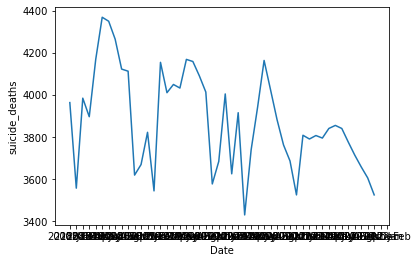

In [9]:
sns.lineplot(x='Date', y='suicide_deaths', data=df_suicide_deaths)

#### Plot is inconclusive for Stationarity

<AxesSubplot:xlabel='Date', ylabel='COVID_cases'>

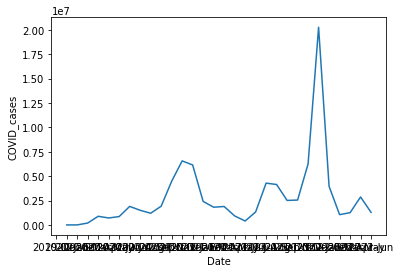

In [10]:
sns.lineplot(x='Date', y='COVID_cases', data=df_COVID_cases)

#### Plot is inconclusive for stationarity

### Smooth the plots

In [11]:
# plot moving average
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

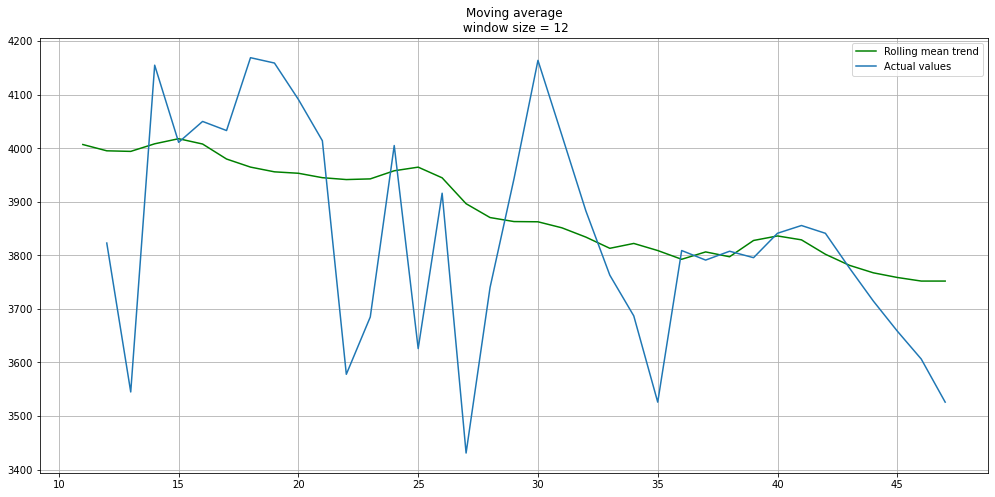

In [12]:
#Smooth by the previous 12 months
plot_moving_average(df_suicide_deaths.suicide_deaths, 12)

#### Smoothing the plot appears to reaval a downward trend

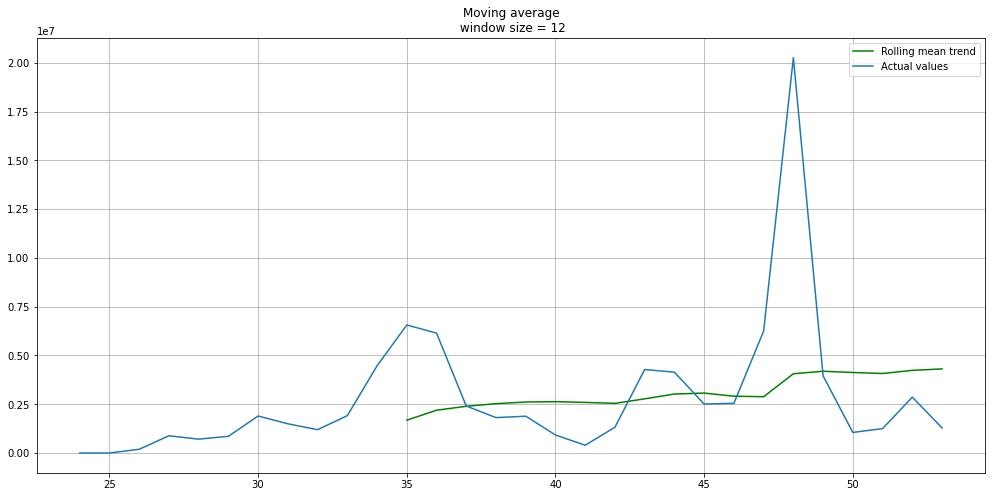

In [13]:
#Smooth by the previous 12 months
plot_moving_average(df_COVID_cases.COVID_cases, 12)

#### Smoothing the plot appears to reaval a slight upward trend

### Summary Statistics

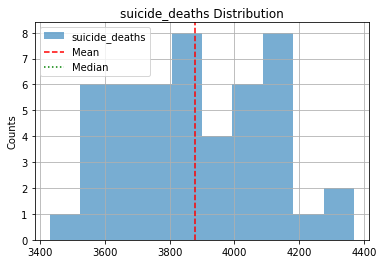

In [14]:
# check histogram
df_suicide_deaths['suicide_deaths'].hist(bins=10, label='suicide_deaths', alpha=0.6)
plt.axvline(np.mean(df_suicide_deaths['suicide_deaths']), ls='--', c='r', label='Mean')
plt.axvline(np.median(df_suicide_deaths['suicide_deaths']), ls=':', c='g', label='Median')
plt.ylabel('Counts'),plt.title('suicide_deaths Distribution')
plt.legend()

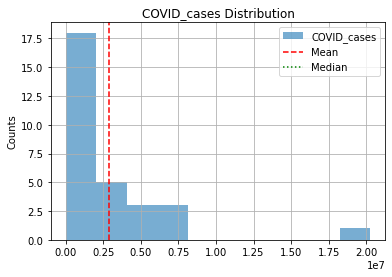

In [15]:
# check histogram
df_COVID_cases['COVID_cases'].hist(bins=10, label='COVID_cases', alpha=0.6)
plt.axvline(np.mean(df_COVID_cases['COVID_cases']), ls='--', c='r', label='Mean')
plt.axvline(np.median(df_COVID_cases['COVID_cases']), ls=':', c='g', label='Median')
plt.ylabel('Counts'),plt.title('COVID_cases Distribution')
plt.legend()

#### Histogram revealed an outlier

In [16]:
#create a function to find outliers using IQR
def find_outliers_IQR(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

In [17]:
# apply def to column
outliers = find_outliers_IQR(df_suicide_deaths['suicide_deaths'])
print('number of outliers: '+ str(len(outliers)))
print('percent of outliers: '+ str(len(outliers)/len(df)*100))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 0
percent of outliers: 0.0
max outlier value: nan
min outlier value: nan


Series([], Name: suicide_deaths, dtype: float64)

In [18]:
# apply def to column
outliers = find_outliers_IQR(df_COVID_cases['COVID_cases'])
print('number of outliers: '+ str(len(outliers)))
print('percent of outliers: '+ str(len(outliers)/len(df)*100))
print('max outlier value: '+ str(outliers.max()))
print('min outlier value: '+ str(outliers.min()))
outliers

number of outliers: 1
percent of outliers: 1.8518518518518516
max outlier value: 20264494.0
min outlier value: 20264494.0


48    20264494.0
Name: COVID_cases, dtype: float64

In [19]:
# impute outier with median
def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()
   df = np.where(df > upper,
       df.median(),
       np.where(
           df < lower,
           df.median(),
           df))
   return df

In [20]:
# fix outlier and recheck descriptive statistics
df_COVID_cases['COVID_cases'] = impute_outliers_IQR(df_COVID_cases['COVID_cases'])
round(df_COVID_cases.describe()['COVID_cases'],2)

C:\Users\drmat\AppData\Local\Temp\ipykernel_12964\216788774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_COVID_cases['COVID_cases'] = impute_outliers_IQR(df_COVID_cases['COVID_cases'])


count         30.00
mean     2236777.10
std      1840292.96
min            7.00
25%       957122.75
50%      1833771.00
75%      2785550.00
max      6563305.00
Name: COVID_cases, dtype: float64

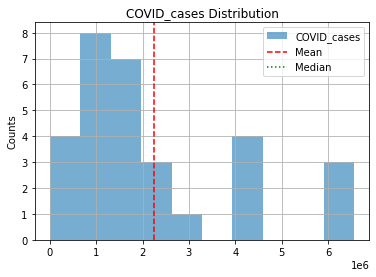

In [21]:
# recheck histogram
df_COVID_cases['COVID_cases'].hist(bins=10, label='COVID_cases', alpha=0.6)
plt.axvline(np.mean(df_COVID_cases['COVID_cases']), ls='--', c='r', label='Mean')
plt.axvline(np.median(df_COVID_cases['COVID_cases']), ls=':', c='g', label='Median')
plt.ylabel('Counts'),plt.title('COVID_cases Distribution')
plt.legend()

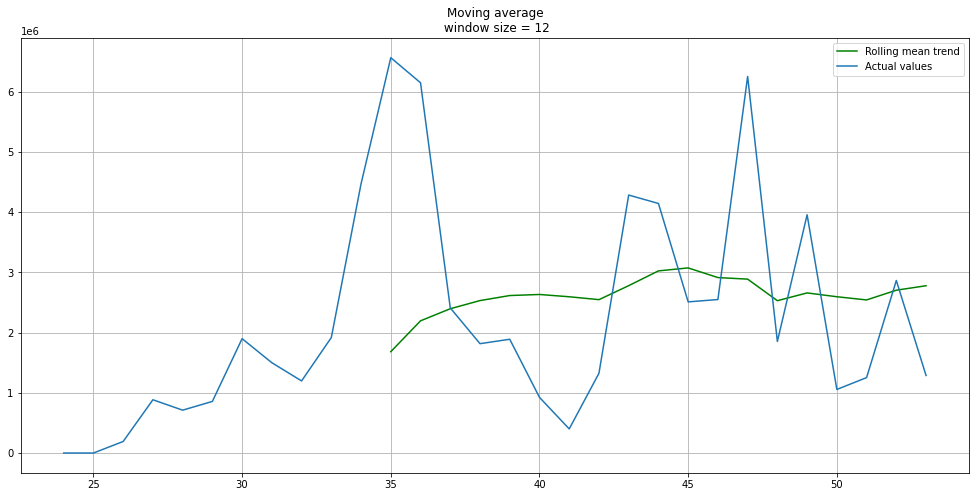

In [22]:
# recheck smooth by the previous 12 months
plot_moving_average(df_COVID_cases.COVID_cases, 12)

### Check mean and variance

In [23]:
# check statistical properties mean, variance to see if constant over time
X = df_suicide_deaths['suicide_deaths']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3960.851852, mean2=3770.723624
variance1=59901.284900, variance2=28401.571013


#### Differences in mean1 and mean2, and variance1 and variance2 suggest non-stationary series

In [25]:
# check statistical properties mean, variance to see if constant over time
X = df_COVID_cases['COVID_cases']
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=63975.333333, mean2=2478199.518519
variance1=12273732174.333332, variance2=3171239548256.721191


#### Differences in mean1 and mean2, and variance1 and variance2 suggest non-stationary series

### Decomposition of dataframes

In [26]:
# Set the "Date" column as the index
from datetime import datetime

df_suicide_deaths['datetime'] = pd.to_datetime(df_suicide_deaths['Date']) # Create a datetime column from "Date.""
df_suicide_deaths = df_suicide_deaths.set_index('datetime') # Set the datetime as the index of the dataframe.
df_suicide_deaths.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_suicide_deaths.head()

C:\Users\drmat\AppData\Local\Temp\ipykernel_12964\2777579014.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suicide_deaths['datetime'] = pd.to_datetime(df_suicide_deaths['Date']) # Create a datetime column from "Date.""


,suicide_deaths
datetime,
2018-01-01,3964.0
2018-02-01,3558.0
2018-03-01,3985.0
2018-04-01,3897.0
2018-05-01,4169.0


In [27]:
# Set the "Date" column as the index

df_COVID_cases['datetime'] = pd.to_datetime(df_COVID_cases['Date']) # Create a datetime column from "Date.""
df_COVID_cases = df_COVID_cases.set_index('datetime') # Set the datetime as the index of the dataframe.
df_COVID_cases.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
df_COVID_cases.head()

C:\Users\drmat\AppData\Local\Temp\ipykernel_12964\1340222637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_COVID_cases['datetime'] = pd.to_datetime(df_COVID_cases['Date']) # Create a datetime column from "Date.""


,COVID_cases
datetime,
2018-01-01,NaN
2018-02-01,NaN
2018-03-01,NaN
2018-04-01,NaN
2018-05-01,NaN


In [28]:
df_suicide_deaths.fillna(0,inplace=True)

In [29]:
df_COVID_cases.fillna(0,inplace=True)

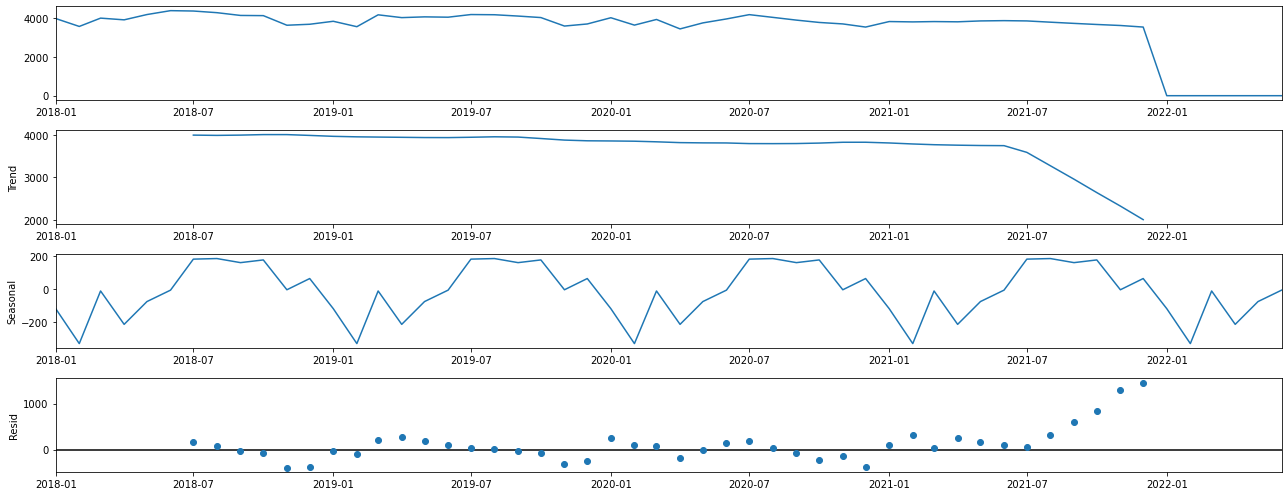

In [30]:
 # Using .api imports the public access version of statsmodels, which is a library that handles statistical models.
import statsmodels.api as sm

# Decompose the time series using an additive model
decomposition_suicide_deaths = sm.tsa.seasonal_decompose(df_suicide_deaths, model='additive')

# This will define a fixed size for all special charts.
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

# Plot the separate components
decomposition_suicide_deaths.plot()
plt.show()

#### Level
#### Trend - beacuse the level and trend look similar there is not much "noise' in the dataframe
#### Seasonality - there does appear to be some seasonality present
#### Residual - there does appear to be some noise especially around 2022

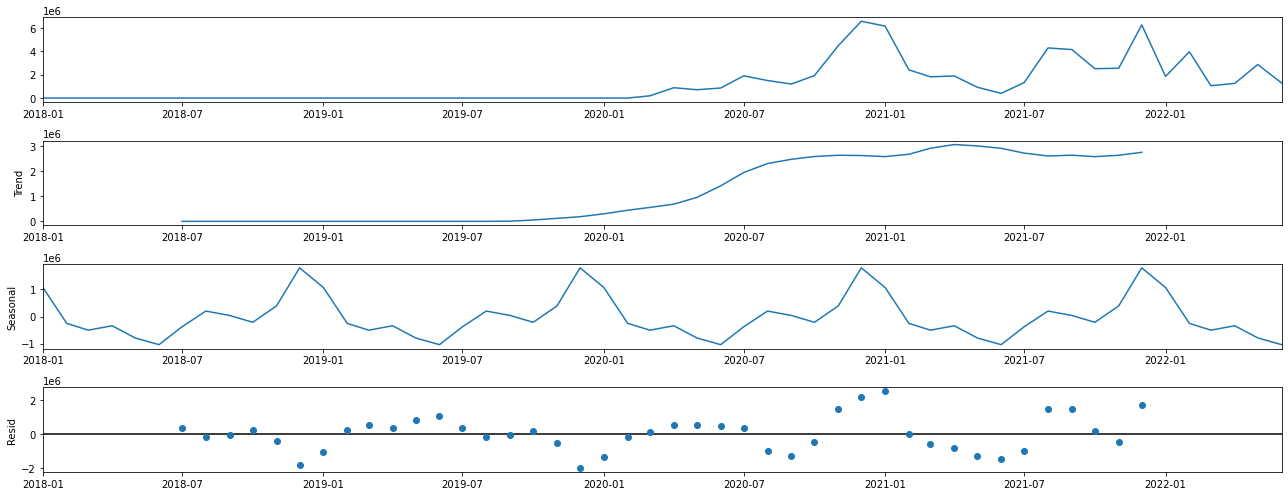

In [31]:
# Decompose the time series using an additive model
decomposition_COVID_cases = sm.tsa.seasonal_decompose(df_COVID_cases, model='additive')

# Plot the separate components
decomposition_COVID_cases.plot()
plt.show()

#### Level
#### Trend - beacuse the level and trend look different there is some "noise' in the dataframe
#### Seasonality - there does appear to be some seasonality present
#### Residual - there does appear to be some noise throughout the dataframe

### Statistical Tests

#### Dickey-Fuller Stationarity test

In [32]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

In [33]:
# Apply the test using the function on the time series
dickey_fuller(df_suicide_deaths['suicide_deaths'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.302431
p-value                         0.925159
Number of Lags Used             0.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


#### Test statistic smaller than critical value = can reject null hypothesis
there is NOT a unit root in your data, and your data is stationary

In [34]:
# Apply the test using the function on the time series
dickey_fuller(df_COVID_cases['COVID_cases'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.836276
p-value                         0.808233
Number of Lags Used            11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


#### Test statistic smaller than critical value = can reject null hypothesis
there is NOT a unit root in your data, and your data is stationary

### Autocorrelations

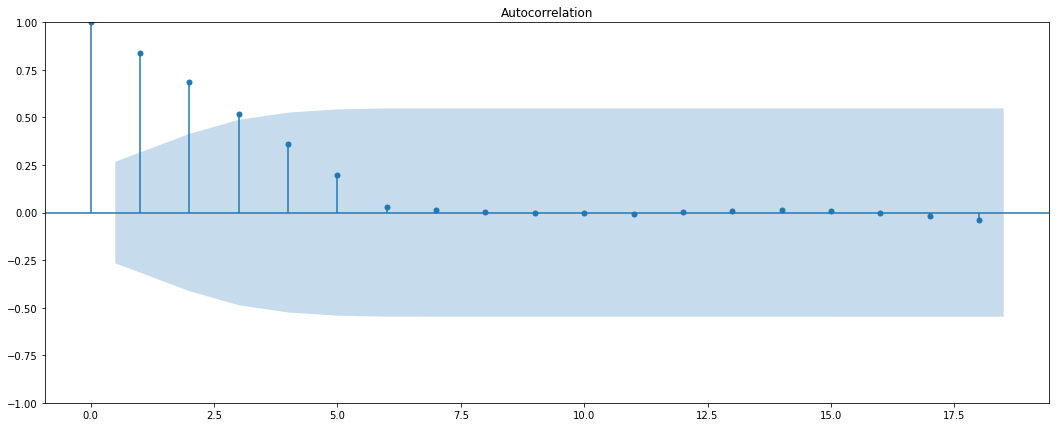

In [35]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(df_suicide_deaths)
plt.show()

####  Only a few lines go above the blue edge of the confidence interval. This means that there are only a few lags that are significantly correlated with each other which indicates that the data is stationary.

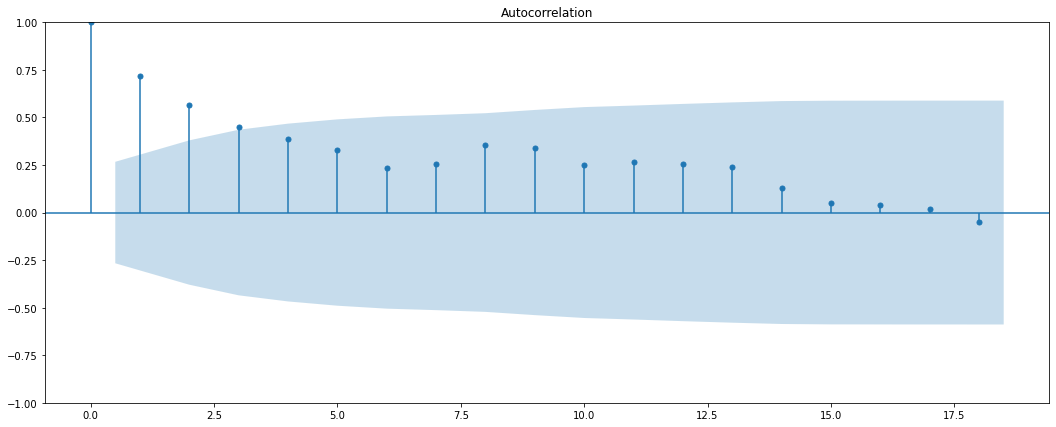

In [36]:
plot_acf(df_COVID_cases)
plt.show()

####  Only a few lines go above the blue edge of the confidence interval. This means that there are only a few lags that are significantly correlated with each other which indicates that the data is stationary.

## Overall testing reveals that the data should be stationary enough for time series analysis.